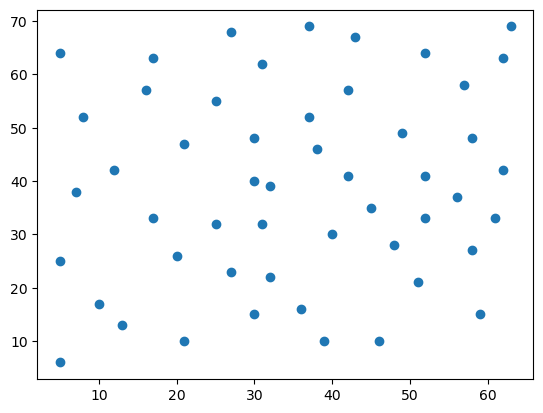

In [2]:
# Reading file

import numpy as np
import matplotlib.pyplot as plt

class City:
    id: int
    x: float
    y: float

    def __init__(self, id, x, y):
        self.x = float(x)
        self.y = float(y)
        self.id = int(id)

file_name = "eil51.tsp.txt"
intro_lines = 6         # MAKE THEM CONSTANT
cities_amount = 51     # MAKE THEM CONSTANT

cities = []
with open(file_name,"r") as f:
    for i in range(intro_lines):
        f.readline()
    for i in range(cities_amount):
        line = f.readline()
        id, x, y = line.split()
        cities.append(City(id, x, y))

coordinates_x = []
coordinates_y = []
for City in cities:
    coordinates_x.append(City.x)
    coordinates_y.append(City.y)
plt.scatter(coordinates_x, coordinates_y)

True
1674.8263713611536


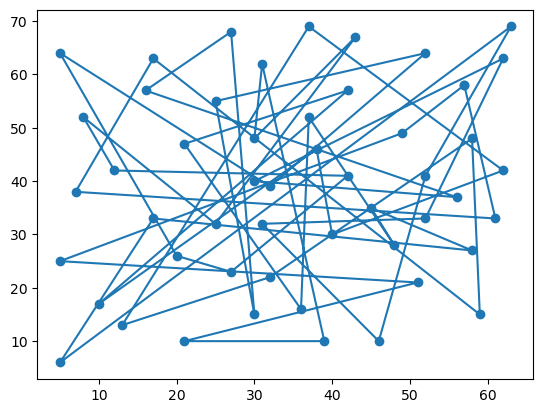

True
800.1093481579065


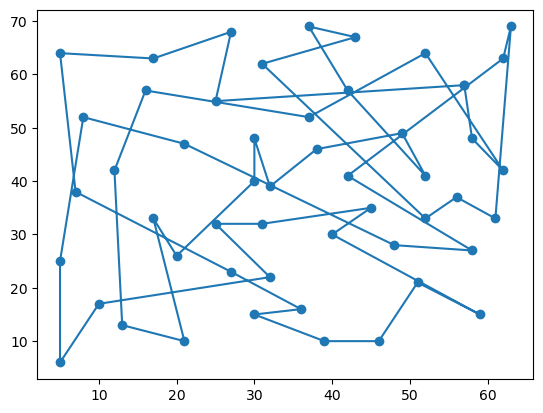

1522.5694285101395
1395.6886428009614
1288.3279779701181
1196.3045509722526
1116.550914240769
1046.7664821007209
985.1919831536197
930.4590952006408
881.4875638742915
837.4131856805768
797.536367314835
761.2847142550697
728.1853788526755
697.8443214004806
669.9305485444614
644.1639889850591
620.3060634670938
598.1522754861263
577.5263349521218
558.2754571203845
540.2665714068237
523.3832410503604
507.5231428367132
492.59599157680987
478.52182038890106
465.2295476003204
452.655776043555
440.7437819371457
429.4426593233727
418.7065928402884
408.49423691735456
398.7681836574175
389.4945049677101
380.64235712753486
372.18363808025634
364.09268942633776
356.3460364598199
348.9221607002403
341.8013002777864
334.9652742722307
328.3973277178732
322.08199449252953
316.0049757285196
310.1530317335469
304.51388570202795
299.0761377430631
293.8291879580971
288.7631674760609
283.86887650189044
279.1377285601923
274.5617002231399
270.13328570341184
265.8454557716117
261.6916205251802
257.66559559402

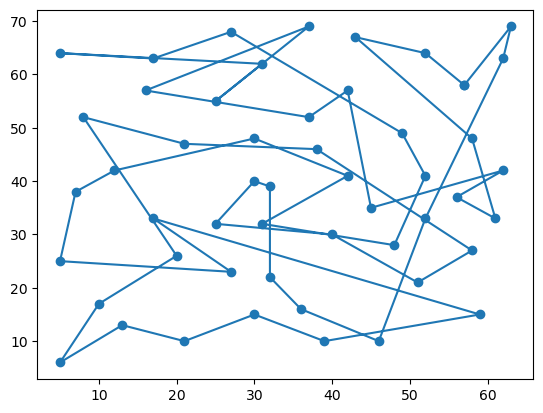

In [21]:
import copy

class Path:
    city_ids = []

    def __init__(self, city_ids = []):
        self.city_ids = copy.deepcopy(city_ids)



# Evaluate Path (Fitness function)
    # Euclidean distance
    def eval_distance(self):
        distance = 0

        for i in range(len(self.city_ids)-1):            
            # Because cities ids are starting from 1, and array starts at 0
            distance += np.sqrt(
            (cities[self.city_ids[i+1]-1].x - cities[self.city_ids[i]-1].x)**2 + 
            (cities[self.city_ids[i+1]-1].y - cities[self.city_ids[i]-1].y)**2 )

        return distance

# Path is invalid if returned to non starting location at the end
    def eval_validity(self):
        if self.city_ids[0] == self.city_ids[-1]:
            return True
        else: return False

# Visualize Path
    def visualize(self):
        coordinates_x = []
        coordinates_y = []
        for i in self.city_ids:
            coordinates_x.append(cities[i-1].x)       # Because cities ids are starting from 1, and array starts at 0
            coordinates_y.append(cities[i-1].y)
        plt.scatter(coordinates_x, coordinates_y)
        plt.plot(coordinates_x, coordinates_y)
        plt.show()



# Optimize Path
    # Rand Permutations +
    # 2-opt
    # 3-opt
    # Other...

    # Rand Permutations, k is amount of swaps
    def generate_new_path_random_swapping(self, k):
        ids_to_swap = np.random.randint(1, len(self.city_ids)-1, k*2)   # We are not swapping start and end
        city_ids_new = copy.deepcopy(self.city_ids)
        for j in range(0, k, 2):
            city_ids_new[ids_to_swap[j]], city_ids_new[ids_to_swap[j+1]] = city_ids_new[ids_to_swap[j+1]], city_ids_new[ids_to_swap[j]]
        return Path(city_ids_new)
    
    def generate_new_path_insertting(self, k):
        return self
    
    def generate_new_path_k_opt(self, k):
        return self
                


# Simplest way to create initial guess is just to shuffle
import random
random.seed(42)
shuffled = sorted(cities, key=lambda k: random.random())
shuffled.append(shuffled[0])    # So that path is cycle
city_ids_init_path = []
for city in shuffled:
    city_ids_init_path.append(city.id)


initial_path = Path(city_ids_init_path)
print(initial_path.eval_validity())     # If everything is ok it should be True
print(initial_path.eval_distance())     # Evaluate circuit size
initial_path.visualize()                # And see it




# Random Permutations to find the better path
path = initial_path
for i in range(10000):
    new_path = path.generate_new_path_random_swapping(k=5)
    if new_path.eval_distance() < path.eval_distance():
        path = new_path

print(path.eval_validity())     # If everything is ok it should be True
print(path.eval_distance())     # Evaluate circuit size
path.visualize()                # And see it


# Annealing

# begin optimizing
current_path = initial_path
current_energy = initial_path.eval_distance()

# Annealing
temp_max = current_energy
temp_min = 0
temp_current = temp_max

step = 0
step_max = 10000

while step < step_max:
    
    step += 1

    # Get candidate solution
    candidate_path = current_path.generate_new_path_random_swapping(k=5)
    candidate_energy = candidate_path.eval_distance()

    delta_energy = candidate_energy - current_energy    # Positive if solution is better, and is always accepted

    if np.random.random() < np.exp(-delta_energy / temp_current):        # This might be wrong
        current_energy = candidate_energy
        current_path = candidate_path
    
    #temp_current = temp_min + (temp_max - temp_min) * ((step_max - step)/step_max)     # linear additive cooling
    alpha = 0.1
    temp_current = temp_max / (1+0.1*step)    # linear multipl cooling
    # Implement cooling functions here
    #print(temp_current)


# generate some final stats
#self.acceptance_rate = self.accept / self.step
print(current_path.eval_distance())     # Evaluate circuit size
current_path.visualize()                # And see it

# Future Discussions and further optimizations

 PreCalculate Distance between all cities and use lookup table